In [64]:
#Imports
import numpy as np
import pandas as pd
import tensorflow.keras.backend as k
from sklearn.preprocessing import MinMaxScaler,  RobustScaler
from tensorflow import keras
from tensorflow.keras import Sequential, layers, optimizers, losses, regularizers
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import Huber



In [65]:
import numpy as np
import pandas as pd

# Read a specific sheet
df = pd.read_excel(r"MayniladDataSet.xlsx",
                   sheet_name='04-VAL04H-PM-1 MIRANDA-PSAN_Pre')

df.head(20)

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
5,PMP,04-VAL04H-PM-1 MIRANDA-PSAN_Pressure,DATETIME,PSI
6,NaN,NaN,2022-01-01 00:00:00,[-11057] Not Enough Values For Calculation
7,NaN,NaN,2022-01-01 00:15:00,[-11057] Not Enough Values For Calculation
8,NaN,NaN,2022-01-01 00:30:00,[-11057] Not Enough Values For Calculation
9,NaN,NaN,2022-01-01 00:45:00,[-11057] Not Enough Values For Calculation


In [66]:
# Don't use this unless you're gonna change your prv dataset.
# to clean

df.drop(['Unnamed: 1', 'Unnamed: 0'], axis=1, inplace=True)
df.to_csv('Dataset.csv', index=False)
df.head(100)

,Unnamed: 2,Unnamed: 3
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
95,2022-01-01 22:15:00,[-11057] Not Enough Values For Calculation
96,2022-01-01 22:30:00,[-11057] Not Enough Values For Calculation
97,2022-01-01 22:45:00,[-11057] Not Enough Values For Calculation
98,2022-01-01 23:00:00,[-11057] Not Enough Values For Calculation


In [67]:
import numpy as np
import pandas as pd
#Cleaning changing Not enough values to NaN
df3 = pd.read_csv("Dataset.csv", skiprows=6)
df3.columns = ['DATETIME', 'PSI']
df3.replace('[-11057] Not Enough Values For Calculation', np.nan, inplace=True)
#changing data types

df3['PSI'] = pd.to_numeric(df3['PSI'], errors='coerce')
df3['DATETIME'] = pd.to_datetime(df3['DATETIME'], errors='coerce')
df3.dtypes
df3

,DATETIME,PSI
0,2022-01-01 00:00:00,NaN
1,2022-01-01 00:15:00,NaN
2,2022-01-01 00:30:00,NaN
3,2022-01-01 00:45:00,NaN
4,2022-01-01 01:00:00,NaN
...,...,...
101659,2024-11-24 22:45:00,7.81
101660,2024-11-24 23:00:00,9.23
101661,2024-11-24 23:15:00,9.94
101662,2024-11-24 23:30:00,8.52


In [68]:
# Creates a separate copy
df_new = df3.copy()  
# Set the index to the 'DATETIME' column
df_new.index = df_new['DATETIME'] 
df_new.drop('DATETIME', axis=1, inplace=True)

df_new




,PSI
DATETIME,
2022-01-01 00:00:00,NaN
2022-01-01 00:15:00,NaN
2022-01-01 00:30:00,NaN
2022-01-01 00:45:00,NaN
2022-01-01 01:00:00,NaN
...,...
2024-11-24 22:45:00,7.81
2024-11-24 23:00:00,9.23
2024-11-24 23:15:00,9.94


In [69]:
#df_new.loc[df_new['PSI'] > 30, 'PSI'] = np.nan
df_new['PSI'] = df_new['PSI'].interpolate(method='time')
df_new['PSI'] = df_new['PSI'].rolling(window=5, center=True).median()

In [70]:
df_new.fillna(0, inplace=True)

df_new

,PSI
DATETIME,
2022-01-01 00:00:00,0.00
2022-01-01 00:15:00,0.00
2022-01-01 00:30:00,0.00
2022-01-01 00:45:00,0.00
2022-01-01 01:00:00,0.00
...,...
2024-11-24 22:45:00,8.52
2024-11-24 23:00:00,8.52
2024-11-24 23:15:00,9.23


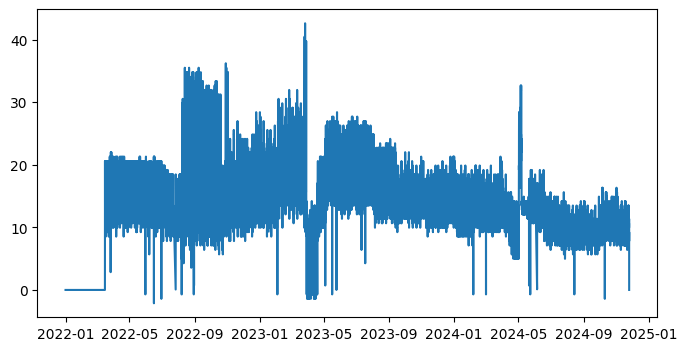

In [71]:
#visualizing my dataframe
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))

# Plot using numerical indices on the x-axis
plt.plot(df_new.index, df_new['PSI'], label='PSI')
# Formatting




In [72]:
df_new['PSI']




DATETIME
2022-01-01 00:00:00    0.00
2022-01-01 00:15:00    0.00
2022-01-01 00:30:00    0.00
2022-01-01 00:45:00    0.00
2022-01-01 01:00:00    0.00
                       ... 
2024-11-24 22:45:00    8.52
2024-11-24 23:00:00    8.52
2024-11-24 23:15:00    9.23
2024-11-24 23:30:00    0.00
2024-11-24 23:45:00    0.00
Name: PSI, Length: 101664, dtype: float64

In [73]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
len(df_new)



101664

In [74]:
train = df_new.iloc[:81331]
test = df_new.iloc[81331:]
train

,PSI
DATETIME,
2022-01-01 00:00:00,0.00
2022-01-01 00:15:00,0.00
2022-01-01 00:30:00,0.00
2022-01-01 00:45:00,0.00
2022-01-01 01:00:00,0.00
...,...
2024-04-27 03:30:00,13.49
2024-04-27 03:45:00,12.78
2024-04-27 04:00:00,12.07


In [75]:
len(train)


81331

In [76]:
len(test)

20333

In [77]:
test

,PSI
DATETIME,
2024-04-27 04:45:00,10.65
2024-04-27 05:00:00,9.23
2024-04-27 05:15:00,9.23
2024-04-27 05:30:00,8.52
2024-04-27 05:45:00,7.81
...,...
2024-11-24 22:45:00,8.52
2024-11-24 23:00:00,8.52
2024-11-24 23:15:00,9.23


In [78]:
# scaling
scaler.fit(df_new)


MinMaxScaler()

In [79]:
scaled_data = scaler.transform(df_new)


In [80]:
def create_multi_step_sequences(data, input_length, output_length):
    X, y = [], []
    for i in range(len(data) - input_length - output_length + 1):
        X.append(data[i:i + input_length])
        y.append(data[i + input_length:i + input_length + output_length])
    return np.array(X), np.array(y)

In [81]:
INPUT_LENGTH = 180
OUTPUT_LENGTH = 30

X, y = create_multi_step_sequences(scaled_data, INPUT_LENGTH, OUTPUT_LENGTH)

# Reshape for LSTM input (samples, time steps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)    

# Train-Test Split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Print shapes
print("X_train shape:", X_train.shape)  # (samples, 180, 1)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)  # (samples, 30)
print("y_test shape:", y_test.shape)


X_train shape: (81164, 180, 1)
X_test shape: (20291, 180, 1)
y_train shape: (81164, 30, 1)
y_test shape: (20291, 30, 1)


In [82]:
#building model
model = Sequential([
    LSTM(96, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)  # Final output
])

c:\Users\William\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [83]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 180, 96)        │        37,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 180, 96)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,905 (312.13 KB)

 Trainable params: 79,905 (312.13 KB)

 Non-trainable params: 0 (0.00 B)

In [84]:
# Compile model with Huber loss and Adam optimizer
model.compile(
    optimizer=Adam(learning_rate=0.05),
    loss=Huber(delta=1),
    metrics=['mae']
)

# Reduce LR if validation loss stops improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1)

# Model checkpoint to save the best model
model_checkpoint = ModelCheckpoint(
    filepath="PredictOneHour.keras",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)

# Train the model
# history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[ reduce_lr, model_checkpoint],
    verbose=1
)

IndentationError: unexpected indent (2168560722.py, line 22)

In [ ]:
# Load the model
best_model = load_model("PredictOneHour.keras")

# Generate predictions
y_pred = best_model.predict(X_test)

635/635 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step


635/635 ━━━━━━━━━━━━━━━━━━━━ 28s 43ms/step


ValueError: x and y must have same first dimension, but have shapes (30,) and (1,)

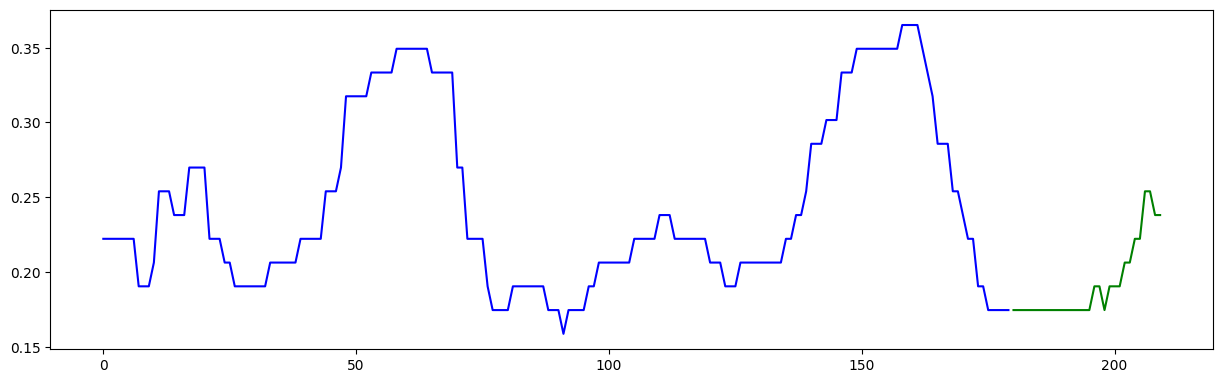

In [101]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions(model, X_test, y_test, num_samples=3, start_idx=0):
    """
    Plot actual vs predicted sequences for multi-step forecasting
    
    Args:
        model: Trained Keras model
        X_test: Test input sequences (samples, input_length, features)
        y_test: Test output sequences (samples, output_length, features)
        num_samples: Number of samples to plot
        start_idx: Starting index in test set to plot from
    """
    # Get predictions
    predictions = model.predict(X_test)
    
    # Squeeze dimensions if needed (remove single-dimensional entries)
    predictions = np.squeeze(predictions)
    y_test = np.squeeze(y_test)
    
    plt.figure(figsize=(15, 5 * num_samples))
    
    for i in range(num_samples):
        idx = start_idx + i
        
        # Create time axis
        input_length = X_test.shape[1]
        output_length = y_test.shape[1]
        total_length = input_length + output_length
        
        # Create x-axis values
        x_input = np.arange(input_length)
        x_output = np.arange(input_length, input_length + output_length)
        
        plt.subplot(num_samples, 1, i+1)
        
        # Plot input sequence
        plt.plot(x_input, X_test[idx], 'b-', label='Input sequence')
        
        # Plot actual output
        plt.plot(x_output, y_test[idx], 'g-', label='Actual output')
        
        # Plot predicted output
        plt.plot(x_output, predictions[idx], 'r--', label='Predicted output')
        
        plt.axvline(x=input_length-0.5, color='k', linestyle='--')
        plt.title(f'Sample {idx+1}')
        plt.legend()
        plt.xlabel('Time steps')
        plt.ylabel('Value')
    
    plt.tight_layout()
    plt.show()

# Usage example:
plot_predictions(model, X_test, y_test, num_samples=3, start_idx=0)

In [96]:
print(f"Training length: {len(y_train_actual)}")
print(f"Test length: {len(y_test_actual)}")
print(f"Prediction length: {len(y_pred_actual)}")

Training length: 2434920
Test length: 608730
Prediction length: 20291


In [ ]:
best_model = load_model("PredictOneHour.keras")

635/635 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step


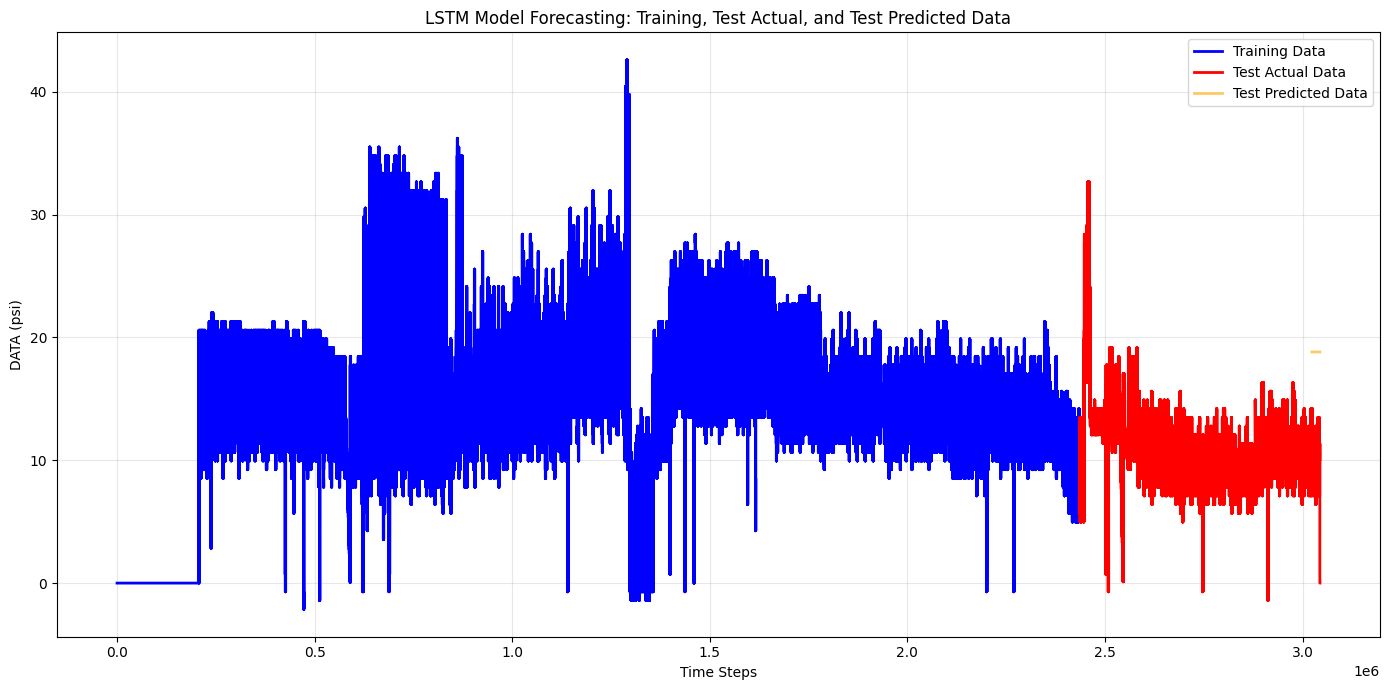

In [90]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np

# Load the best saved model


# Generate predictions for the test set
y_pred = best_model.predict(X_test)

# Inverse transform the scaled data back to original scale
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_actual = scaler.inverse_transform(y_pred)

# Flatten all arrays for plotting
y_train_actual = y_train_actual.flatten()
y_test_actual = y_test_actual.flatten()
y_pred_actual = y_pred_actual.flatten()

# Create time indices
train_index = np.arange(len(y_train_actual))
test_index = np.arange(len(y_train_actual), len(y_train_actual) + len(y_test_actual))

# For multi-step prediction, predictions might be shorter than test data
# Calculate how many steps we need to offset
offset = len(y_test_actual) - len(y_pred_actual)
pred_index = test_index[offset:]  # Align predictions with the end of test period

# Plotting
plt.figure(figsize=(14, 7))

# Plot training data
plt.plot(train_index, y_train_actual, label="Training Data", color="blue", linewidth=2)

# Plot test actual data
plt.plot(test_index, y_test_actual, label="Test Actual Data", color="red", linewidth=2)

# Plot test predicted data (aligned properly)
plt.plot(pred_index, y_pred_actual, label="Test Predicted Data", color="orange", linewidth=2, alpha=0.6)

# Formatting
plt.title("LSTM Model Forecasting: Training, Test Actual, and Test Predicted Data")
plt.xlabel("Time Steps")
plt.ylabel("DATA (psi)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

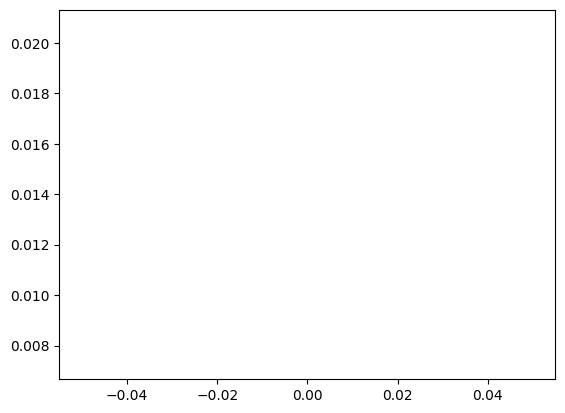

In [ ]:

loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
loss_per_epoch = model.history.history['val_loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [91]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# SMAPE function
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-10))  # Avoid division by zero

# MAPE function
def mape(y_true, y_pred):
    return 100 * np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10)))  # Avoid division by zero

# Check the shape of y_pred
print("y_pred shape:", y_pred.shape)

# If y_pred is 2D, no slicing is needed
if len(y_pred.shape) == 2:
    y_pred = y_pred[:, 0]  # Take the first step of the multi-step forecast
elif len(y_pred.shape) == 3:
    y_pred = y_pred[:, 0, :]  # For 3D arrays, take the first step

# Calculate SMAPE
smape_value = smape(y_test, y_pred)
print(f"SMAPE: {smape_value:.2f}%")

# Calculate MAPE
mape_value = mape(y_test, y_pred)
print(f"MAPE: {mape_value:.4f}%")

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f'MAE: {mae:.4f}')

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse:.4f}')

y_pred shape: (20291, 1)


MemoryError: Unable to allocate 92.0 GiB for an array with shape (20291, 30, 20291) and data type float64